In [1]:
from warnings import filterwarnings

filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from crypto_momentum_portfolios.utility.data_loader import CryptoDataLoaderQIL
from crypto_momentum_portfolios.utility.types import (
    DataFrequency,
    Fields,
    RebalanceFrequency,
    Side,
    AllocationMethod,
    Benchmark,
)
from crypto_momentum_portfolios.portfolio_management.benchmarks import (
    BenchmarkDataFrameBuilder,
)
from crypto_momentum_portfolios.portfolio_management.backtester import (
    PortfolioBacktester,
)

dl = CryptoDataLoaderQIL()  # CryptoDataLoader()
dl.assets

Loading BokehJS ...

Fetching symbols...: 100%|██████████| 21/21 [00:21<00:00,  1.02s/it]


['ETC-USDT',
 'BCH-USDT',
 'XTZ-USDT',
 'ATOM-USDT',
 'BTC-USDT',
 'TRX-USDT',
 'XLM-USDT',
 'XRP-USDT',
 'MATIC-USDT',
 'DASH-USDT',
 'DOGE-USDT',
 'VET-USDT',
 'BNB-USDT',
 'EOS-USDT',
 'SOL-USDT',
 'ADA-USDT',
 'AVAX-USDT',
 'LTC-USDT',
 'LINK-USDT',
 'KDA-USDT',
 'ETH-USDT']

In [2]:
MOMENTUM_LOOKBACK = 30
universe = (
    dl.get_crypto(
        "all",
        data_frequency=DataFrequency.DAILY,
        fields=[
            Fields.PRICE,
            Fields.MARKET_CAP,
            Fields.MOMENTUM,
            Fields.RETURNS,
            Fields.VOLUME,
        ],
        flatten_fields_with_crypto=False,
        momentum_lookback=MOMENTUM_LOOKBACK,
    )
    .dropna()
    .loc[:]  # "2021-10-28"
)
universe.head()

price                                                           \
           ETC-USDT BCH-USDT XTZ-USDT ATOM-USDT BTC-USDT  TRX-USDT  XLM-USDT   
Date                                                                           
2021-09-02  67.6071   664.49  5.29412   24.1422  49248.9  0.099526  0.359000   
2021-09-03  69.9936   713.32  5.31364   24.1158  50011.0  0.101654  0.368773   
2021-09-04  68.7689   708.80  5.40328   24.3884  49902.6  0.101457  0.369760   
2021-09-05  73.5208   765.00  5.56640   25.7148  51768.0  0.105212  0.397779   
2021-09-06  73.4993   784.61  5.59636   25.1007  52667.2  0.103767  0.423930   

                                          ...        volume                \
           XRP-USDT MATIC-USDT DASH-USDT  ...      VET-USDT      BNB-USDT   
Date                                      ...                               
2021-09-02  1.25337     1.4453    239.03  ...  4.366786e+07  2.798852e+07   
2021-09-03  1.29075     1.4559    247.46  ...  3.520757e+07  2.585108e+07   
2021-09-04  1.25500     1.7374    251.55  ...  2.508443e+07  3.431727e+07   
2021-09-05  1.30769     1.6803    264.30  ...  2.032786e+07  2.350295e+07   
2021-09-06  1.38957     1.6435    255.46  ...  2.940524e+07  2.661392e+07   

                                                                    \
                EOS-USDT      SOL-USDT      ADA-USDT     AVAX-USDT   
Date                                                                 
2021-09-02  8.027218e+06  3.756954e+07  1.663876e+08  1.260635e+07   
2021-09-03  1.095528e+07  5.825224e+07  8.195590e+07  2.368620e+07   
2021-09-04  1.176539e+07  3.278846e+07  7.513698e+07  1.644097e+07   
2021-09-05  1.376169e+07  2.985273e+07  4.961102e+07  1.239841e+07   
2021-09-06  1.304758e+07  4.597036e+07  6.301220e+07  1.999695e+07   

                                                                    
                LTC-USDT     LINK-USDT      KDA-USDT      ETH-USDT  
Date                                                                
2021-09-02  1.063425e+07  1.839220e+07  7.926466e+05  2.377383e+08  
2021-09-03  3.419287e+07  1.698059e+07  1.065176e+06  2.619353e+08  
2021-09-04  2.554847e+07  1.015540e+07  6.648969e+05  1.661564e+08  
2021-09-05  2.442621e+07  1.718075e+07  8.942949e+05  1.646614e+08  
2021-09-06  2.233272e+07  3.100928e+07  2.234403e+06  1.615486e+08  

[5 rows x 105 columns]

Weight drift :

$$w_i^k=\frac{w_{i-1}^k\times (1+r_i^k)}{\sum_{j=1}^n w_{i-1}^j\times(1+r_i^j)}$$

For asset $k$ at time $i$ given $n$ asset in the portfolio.


# Building a benchmark


## Capitalization weighted index


In [3]:
benchmarks = (
    BenchmarkDataFrameBuilder(universe)
    .build_equally_weighted_benchmark(
        rebalance_frequency=RebalanceFrequency.MONTHLY, side=Side.LONG, verbose=False
    )
    .build_capitalization_weighted_benchmark(
        capitalization_field=Fields.MARKET_CAP,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        verbose=False,
    )
    .build_bitcoin_benchmark()
    .collect_benchmark_returns()
)
benchmarks

,equal_weighted_benchmark,capi_weighted_benchmark,bitcoin_benchmark
Date,,,
2021-09-02,-0.004464,-0.006258,0.008882
2021-09-03,0.032272,0.026301,0.015474
2021-09-04,0.002686,-0.012745,-0.002168
2021-09-05,0.052077,0.034408,0.037381
2021-09-06,0.013265,0.010569,0.017370
...,...,...,...
2023-12-23,0.001327,0.005436,0.004439
2023-12-24,0.054098,0.034923,0.000096
2023-12-25,0.021938,0.016110,-0.007389


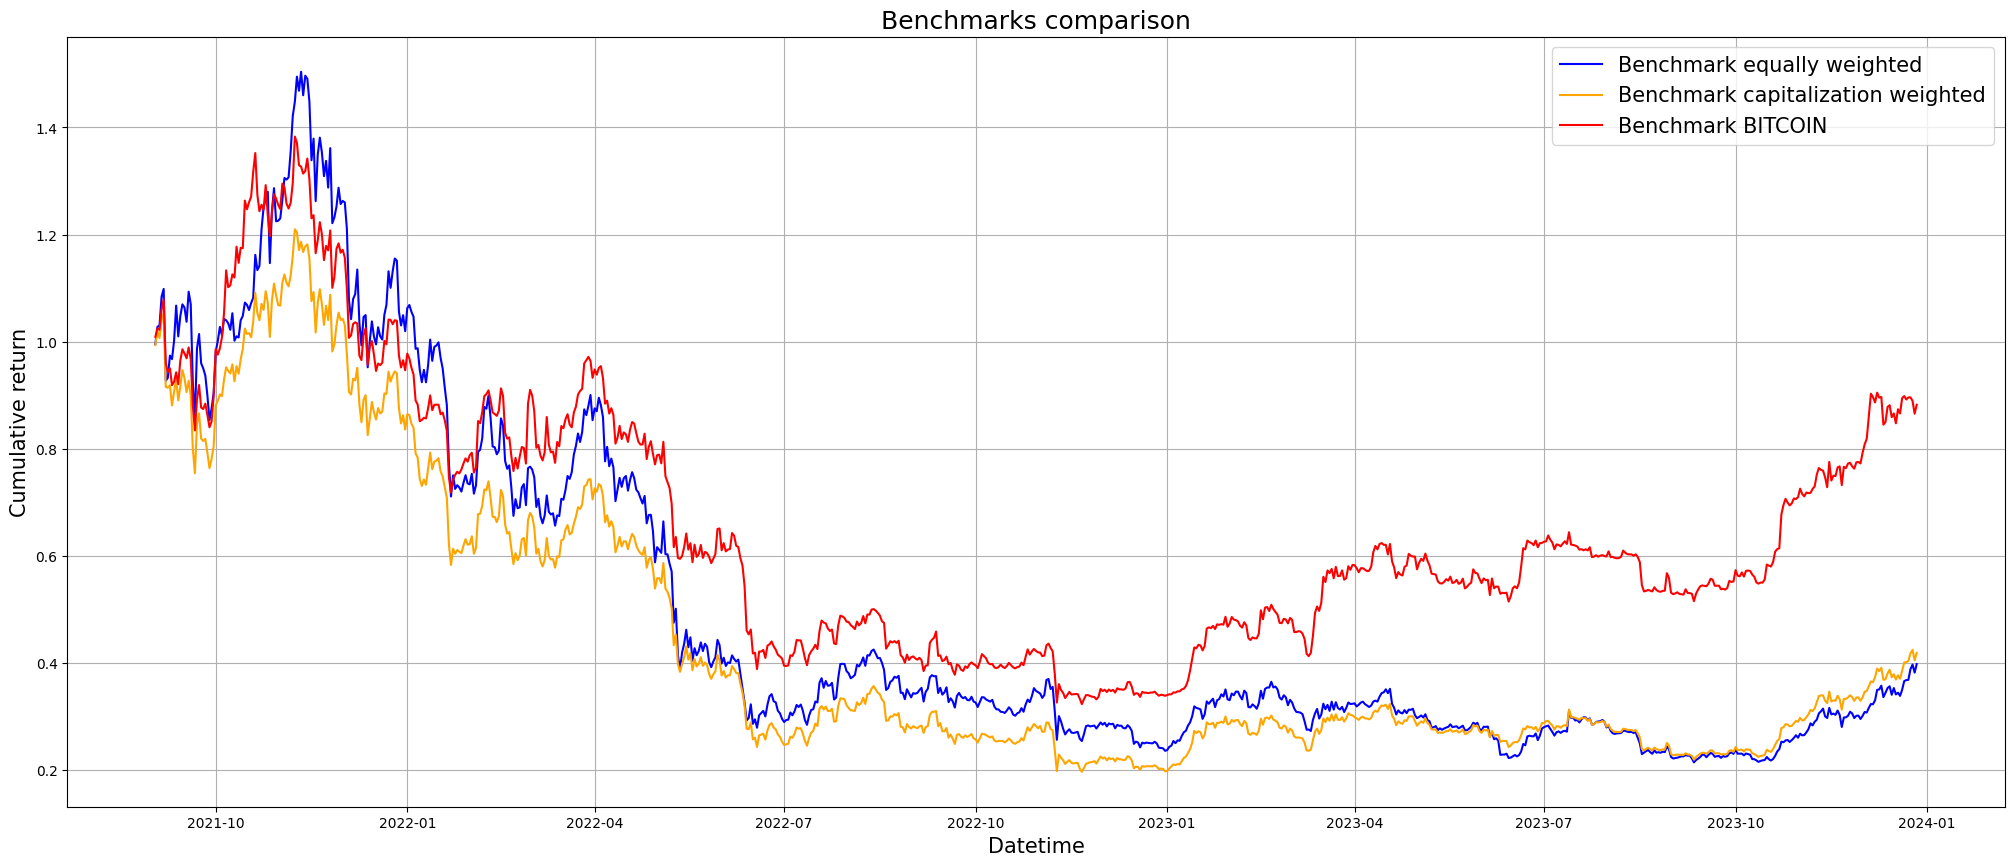

In [4]:
f, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title("Benchmarks comparison", fontsize=18)
ax.grid()
ax.plot(
    (benchmarks["equal_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark equally weighted",
    color="blue",
)
ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark capitalization weighted",
    color="orange",
)
ax.plot(
    (benchmarks["bitcoin_benchmark"] + 1).cumprod(),
    label="Benchmark BITCOIN",
    color="red",
)


ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper right", fontsize=15)
# ax.set_yscale("log")

# Backtesting strategies


## Backtesting with a benchmark and a strategy


In [5]:
ptf_backtester = PortfolioBacktester(universe=universe.loc[:])

returns_capi, _ = ptf_backtester.run_strategy(
    select_top_k_assets=5,
    allocation_method=AllocationMethod.MOMENTUM_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.QUARTER_START,
    side=Side.LONG,
    benchmark=Benchmark.CAPITALIZATION_WEIGHTED,
    verbose=False,
    print_stats=True,
    plot_curve=True,
)


-----------------Expected return------------------
Benchmark: -16.24% vs Strategy: 70.52%

t-stat: 25.96, p-value: 0.00
Statistically different from the bench

-----------------------CAGR-----------------------
Benchmark: -31.07% vs Strategy: 29.51%

t-stat: 14.51, p-value: 0.00
Statistically different from the bench

---------------Expected volatility----------------
Benchmark: 64.82% vs Strategy: 91.55%

t-stat: 118.66, p-value: 0.00
Statistically different from the bench

---------------------Skewness---------------------
Benchmark: -0.33 vs Strategy: 0.28

t-stat: 34.78, p-value: 0.00
Statistically different from the bench

---------------------Kurtosis---------------------
Benchmark: 2.96 vs Strategy: 4.23

t-stat: 18.44, p-value: 0.00
Statistically different from the bench

-----------------------VaR------------------------
Benchmark: -5.73% vs Strategy: -7.50%

t-stat: -67.51, p-value: 0.00
Statistically different from the bench

-----------------------CVaR---------------------

Loading BokehJS ...

Loading BokehJS ...

## Several strategies


In [ ]:
ptf_backtester = PortfolioBacktester(universe=universe)

returns_capi, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.CAPITALIZATION_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_capi.name = "capitalization_weighted"

returns_rp, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.RISK_PARITY,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_rp.name = "risk_parity"
returns_mv, _ = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.MEAN_VARIANCE,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns_mv.name = "mean_variance"
returns, weights_df = ptf_backtester.run_strategy(
    allocation_method=AllocationMethod.EQUAL_WEIGHTED,
    rebalance_frequency=RebalanceFrequency.MONTHLY,
    side=Side.LONG,
    verbose=False,
    print_stats=False,
    plot_curve=False,
)
returns.name = "equal_weighted"

In [ ]:
returns_df = pd.concat([returns, returns_capi, returns_rp, returns_mv], axis=1)
returns_df

### Plot all strategies


In [ ]:
ax = (returns_df + 1).cumprod().plot(figsize=(25, 10), grid=True)

ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)

ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="capi_weighted_benchmark",
    color="black",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
# ax.set_yscale("log")

### Plot one strategy


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(25, 10))

ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)
ax.plot(
    (returns_df["mean_variance"] + 1).cumprod(),
    label="Stretegy",
    color="blue",
)

ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="capi_weighted_benchmark",
    color="orange",
)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
# ax.set_yscale("log")

ax.grid()

## Weights analysis


In [ ]:
weights_df